In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ekphrasis

     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 184kB 12.7MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp37-none-any.whl size=82844 sha256=161b3f6a94e792c68a458e89bf387fcabdc5800d1cf8198c11b002ef14f90593
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=08b668718fdc1468b8a6194025e77d5ae93b5733156195fd33d345d0cdf75583
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ekphrasis ftfy


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 19.9MB/s 
     |████████████████████████████████| 890kB 50.6MB/s 
     |████████████████████████████████| 3.2MB 39.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=8e57b7cf312eeff6aebc5bb14d2484901284e5141772f1b810318c2ec609fc7d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180944 sha256=6150293b658c8ec74f91b12b2cacec172737376654bd1852bec2335fbbcf506d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_6plagbc/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


### Setting up

In [ ]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import codecs
import re
import spacy
import nltk
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, random_split
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from transformers import BertForSequenceClassification, BertTokenizer, RobertaForSequenceClassification, RobertaTokenizer

In [ ]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = "cpu" #torch.device("cuda:0" if use_cuda else "cpu")

### Loading the data

In [ ]:
# Load data
test_df = pd.read_csv('/content/drive/MyDrive/data/task-1/test.csv')

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
test_df.head()

,id,original,edit,grades,meanGrade
0,36,The Latest : Election tally shows <Austria/> t...,Cars,31110,1.2
1,2157,House Intel <Republicans/> Have Cleared Trump ...,onions,11000,0.4
2,9385,Christmas Is Canceled : Nazareth ’s Muslim <Ma...,grump,11111,1.0
3,14434,White House says Trump 's legal <team/> suppor...,bozos,32210,1.6
4,9462,Election <analysts/> move Ryan seat toward Dem...,movers,11000,0.4


### Preprocessing functions

In [ ]:
def capitalisation_by_ner(sentence, entities=['GPE', 'ORG', 'NORP', 'PERSON']):
    edited_row = []

    trial_doc = nlp(sentence)
        
    for tok in trial_doc:
        if tok.ent_type_ in entities:
            edited_row.append(tok.text)
        else:
            edited_row.append(tok.text.lower())
    
    return ' '.join(edited_row)

In [ ]:
# Word replacement
# Join the contractions
# Tokenize
# remove stop words
# remove punct EXCEPT ! ? #
# Twitter handles

def preprocessor(df):
    _df = pd.DataFrame(index=df.index, columns=['edited_sentences', 'meanGrade'])

    _df['meanGrade'] = df.meanGrade

    text_processor = TextPreProcessor(
        fix_html=True,  # fix HTML tokens

        # corpus from which the word statistics are going to be used 
        # for word segmentation 
        segmenter="english", 

        # corpus from which the word statistics are going to be used 
        # for spell correction
        corrector="english", 

        unpack_hashtags=False,  # perform word segmentation on hashtags
        unpack_contractions=False,  # Unpack contractions (can't -> can not)
        spell_correct=True,  # spell correction for elongated words
    )
    
    punct = "[\.,:;\(\)\[\]@\-\$£]"
    
    nltk.download('stopwords')
    stops = stopwords.words('english')

    # Word replacement + join the contractions
    # NOTE: need to deal with ' '
    # NOTE: Numbers/digits have not been removed
    # NOTE: We have removed all stop words. We analysed the sentiment of the stop 
    # words in the training set to determine if removing them would negatively 
    # affect our results. The motivation for this check was that any word with a 
    # sentiment would affect the funniness score of the sentence. 
    # Since stop words have no sentiment, they have been removed
    # This doesn't retain any twitter handles, but retains the hashtags

    _df['edited_sentences'] = df[['original', 'edit']] \
        .apply(lambda x: re.subn("<.*/>", x[1], x[0])[0], axis=1) \
        .apply(lambda x: capitalisation_by_ner(x)) \
        .str.replace(" (?P<one>\w*'\w+)", lambda x: x.group("one")) \
        .apply(lambda x: text_processor.pre_process_doc(x)) \
        .str.replace("#", "# ") \
        .str.replace("[‘’]", "'") \
        .str.replace("'s", "") \
        .str.replace(punct, "") \
        .apply(lambda x: " ".join([w for w in x.split(" ") if w not in stops])) \
        .str.replace("[0-9]", "")

    return _df

### Setting up the models and the evaluation functions

In [ ]:
def model_eval(data_loader, model):
  model.eval()
  preds = []
  targets = []
  rmse = 0
  model = model.to(device)

  with torch.no_grad():
    for batch in data_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          preds.extend(outputs.logits.squeeze(1).detach().cpu().numpy())
          targets.extend(labels.detach().cpu().numpy())

  preds = np.array(preds)
  targets = np.array(targets)
  print(preds, targets)
  model_performance(preds, targets, print_output=True)
  return preds, targets

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [ ]:
class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.x_train.items()}
        item['labels'] = torch.tensor(self.y_train[idx], dtype=torch.float)
        return item

In [ ]:
clean_test_df = preprocessor(test_df)

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
test_data = clean_test_df['edited_sentences']

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/BERT')

In [ ]:
roberta_model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/RoBERTa')

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

### Evaluating the BERT model on unseen test data

In [ ]:
test_X = tokenizer_bert(test_data.to_list(), add_special_tokens=False, padding=True, return_tensors="pt")

In [ ]:
test_dataset = Task1Dataset(test_X, test_df['meanGrade'])

In [ ]:
bert_model = bert_model.to(device)

In [ ]:
BATCH_SIZE = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("Dataloaders created.")


Dataloaders created.


In [ ]:
predictions, target = model_eval(test_loader, bert_model)
model_performance(predictions, target, print_output=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


[0.90434945 1.083286   0.80114436 ... 0.9430454  0.78376645 1.0105428 ] [1.2 0.4 1.  ... 0.4 0.  0.8]
| MSE: 0.32 | RMSE: 0.56 |
| MSE: 0.32 | RMSE: 0.56 |


(962.7962, 0.31838498)

In [ ]:
clean_test_df['predictions_bert'] = predictions

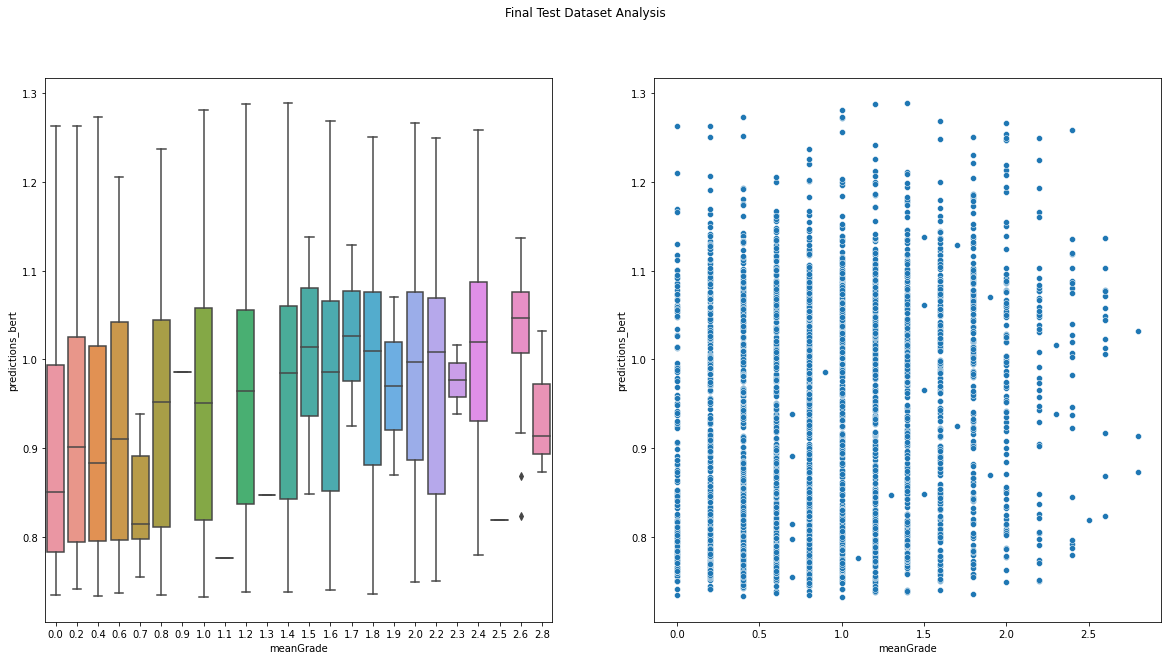

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

 
fig.suptitle('Final Test Dataset Analysis')
sns.boxplot(x='meanGrade', y='predictions_bert', data=clean_test_df, ax=ax1)
sns.scatterplot(x='meanGrade', y='predictions_bert', data=clean_test_df, ax=ax2)
plt.show()

### Evaluating the RoBERTa model on unseen test data

In [ ]:
test_X_roberta = tokenizer_roberta(test_data.to_list(), add_special_tokens=False, padding=True, return_tensors="pt")

In [ ]:
test_dataset_roberta = Task1Dataset(test_X_roberta, test_df['meanGrade'])

In [ ]:
roberta_model = roberta_model.to(device)

In [ ]:
BATCH_SIZE = 32
test_loader_roberta = torch.utils.data.DataLoader(test_dataset_roberta, batch_size=BATCH_SIZE)

print("Dataloaders created.")


Dataloaders created.


In [ ]:
predictions_r, target_r = model_eval(test_loader_roberta, roberta_model)
model_performance(predictions_r, target_r, print_output=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


[1.0880393 1.0329747 0.7156162 ... 1.4082301 1.014096  0.9412225] [1.2 0.4 1.  ... 0.4 0.  0.8]
| MSE: 0.30 | RMSE: 0.55 |
| MSE: 0.30 | RMSE: 0.55 |


(903.5323, 0.29878715)

In [28]:
clean_test_df['predictions_roberta'] = predictions_r
clean_test_df.head()

,edited_sentences,meanGrade,predictions_bert,predictions_roberta
0,latest election tally shows cars turning right,1.2,0.904349,1.088039
1,House Intel onions cleared trump Russia inves...,0.4,1.083286,1.032975
2,christmas canceled Nazareth Muslim grump ban...,1.0,0.801144,0.715616
3,White House says Trump legal bozos supports se...,1.6,1.010115,1.363341
4,election movers move Ryan seat toward Dems ret...,0.4,0.965601,0.811056


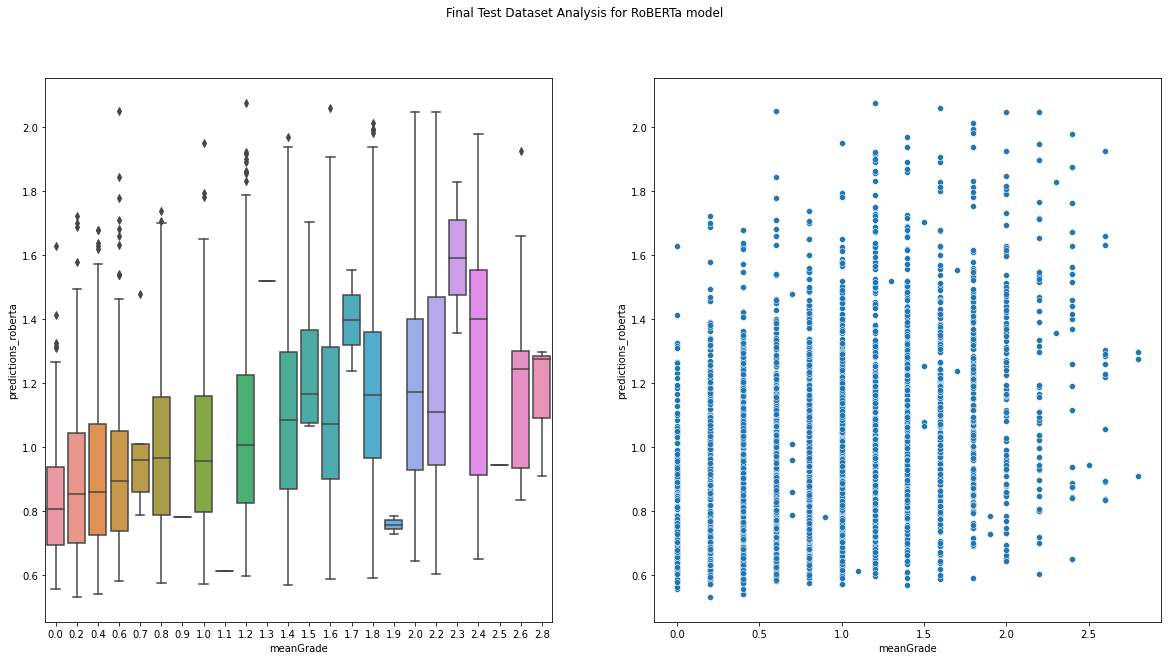

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

 
fig.suptitle('Final Test Dataset Analysis for RoBERTa model')
sns.boxplot(x='meanGrade', y='predictions_roberta', data=clean_test_df, ax=ax1)
sns.scatterplot(x='meanGrade', y='predictions_roberta', data=clean_test_df, ax=ax2)
plt.show()